<a href="https://colab.research.google.com/github/ibonetc/VisionAPI_TensorFlow_Python/blob/master/Esp_AWSAPI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Crear configuración de API

Primero hay que crear un fichero con la configuración de las claves de uusario de AWS.
Crear un usuario en el servicio IAM y crear un fichero .txt con esta estructura:

[default]

aws_access_key_id=

aws_secret_access_key=

[texto del enlace](https://docs.aws.amazon.com/cli/latest/userguide/cli-configure-files.html)

Copiemos el fichero en una carpeta en nuestro Drive, activemos el drive y comencemos:

In [0]:
!mkdir -p ~/.aws &&\
  cp /content/drive/My\ Drive/AWS/credencials.txt ~/.aws/credentials

Probar API con un ejemplo sencillo de análisis de sentimientos en una frase.
Para esto usaremos el servicio de Comprehend de AWS 

In [215]:
import boto3
comprehend = boto3.client(service_name='comprehend', region_name="us-east-2")
text = "Este curso es una maravilla"
comprehend.detect_sentiment(Text=text, LanguageCode='es')

{'ResponseMetadata': {'HTTPHeaders': {'content-length': '166',
   'content-type': 'application/x-amz-json-1.1',
   'date': 'Tue, 31 Mar 2020 22:35:09 GMT',
   'x-amzn-requestid': '8386bd9c-540f-437d-a4ea-5f25b60a1449'},
  'HTTPStatusCode': 200,
  'RequestId': '8386bd9c-540f-437d-a4ea-5f25b60a1449',
  'RetryAttempts': 0},
 'Sentiment': 'POSITIVE',
 'SentimentScore': {'Mixed': 9.114788213082647e-07,
  'Negative': 2.1180041585466824e-05,
  'Neutral': 0.0002277855237480253,
  'Positive': 0.9997500777244568}}

## Análisis de imágenes

Vamos a utilizar el servicio Rekognition

In [0]:
import matplotlib.pyplot as plt
import cv2
from google.colab.patches import cv2_imshow

In [0]:
cisnes='/content/drive/My Drive/Ejemplos R_Otros/Fotos/cisnes.jpg'
face='/content/drive/My Drive/Ejemplos R_Otros/Fotos/face.jpg'
fiesta='/content/drive/My Drive/Ejemplos R_Otros/Fotos/fiesta.jpg'
london='/content/drive/My Drive/Ejemplos R_Otros/Fotos/london.jpg'
nottinghan='/content/drive/My Drive/Ejemplos R_Otros/Fotos/Nottingham.jpg'
cisneNegro='/content/drive/My Drive/Ejemplos R_Otros/Fotos/cisneNegro.jpg'
warwich='/content/drive/My Drive/Ejemplos R_Otros/Fotos/warwick.jpg'
image_text='/content/drive/My Drive/Ejemplos R_Otros/Fotos/text.jpg'
grupoI='/content/drive/My Drive/Ejemplos R_Otros/Fotos/grupoI.jpg'
castilloMedellin='/content/drive/My Drive/Ejemplos R_Otros/Fotos/CastilloMedellin.jpg'
cuba='/content/drive/My Drive/Ejemplos R_Otros/Fotos/Cuba.jpg'

Se debe llamar al servicio ***rekognition***

In [0]:
client = boto3.client(service_name='rekognition', region_name="us-east-2")

Hacer una función para leer la imagen en formato binario

In [0]:
def openImage(file_image):
  with open(file_image, 'rb') as openfile:
    content = openfile.read()
  return content

### Detección de rostro

Para esto hay que tener en cuenta los datos que me dan.

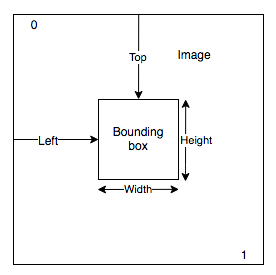

AWS en sus procesos rota las imágenes si ellas están rotadas

La biblioteca ***piexif*** me ayuda a saber si la imagen está rotada

`piexif.load(face)["0th"][piexif.ImageIFD.Orientation]` tendrá un número

*   3: 180º
*   6: 90º
*   8: 270º
*   1: 0º


In [194]:
!pip install piexif

In [0]:
import piexif

In [0]:
image=openImage(face)
response = client.detect_faces(Image={'Bytes': image}, Attributes=["ALL"])

In [213]:
for faceDetail in response['FaceDetails']:
  print('La edad está entre ' + str(faceDetail['AgeRange']['Low']) + ' y ' + str(faceDetail['AgeRange']['High']) + ' años')

La edad está entre 33 y 49 años


In [0]:
img = plt.imread(face)
img=cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
imgWidth = img.shape[1]
imgHeight = img.shape[0]
box=response['FaceDetails'][0]['BoundingBox']
left = int(imgWidth * box['Left'])
top = int(imgHeight * box['Top'])
width = int(imgWidth * box['Width'])
height = int(imgHeight * box['Height'])
img=cv2.rectangle(img,(left,top),(left+width,top+height),(255,0,0),12)

Función para rotar la imagen si tiene el parámetro de rotación

In [0]:
def rotate(filename):
  exif_dict = piexif.load(filename)
  img = plt.imread(filename)
  if piexif.ImageIFD.Orientation in exif_dict["0th"]:
      orientation = exif_dict["0th"][piexif.ImageIFD.Orientation]
      if orientation == 3:# 180 grados
          return cv2.rotate(img, cv2.ROTATE_180)
      elif orientation == 6: # 90 grados
          return cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
      elif orientation == 8:#270
          return cv2.rotate(img, cv2.cv2.ROTATE_90_COUNTERCLOCKWISE)
      else:
          return img
  else:
      return img

Función para trazar un rectángulo en la zona detectada. Se le pasa la imagen y el box que contiene las coordenadas.

Esta nos puede servir para dibujar el rectángulo dada las coordenadas de detección de rostro o de objetos.

In [0]:
def rectFace(img,box):
  imgWidth = img.shape[1]
  imgHeight = img.shape[0]
  left = int(imgWidth * box['Left'])
  top = int(imgHeight * box['Top'])
  width = int(imgWidth * box['Width'])
  height = int(imgHeight * box['Height'])
  img_rotate=cv2.rectangle(img,(left,top),(left+width,top+height),(255,0,0),12)
  return img, [left, top, left+width, top+height]

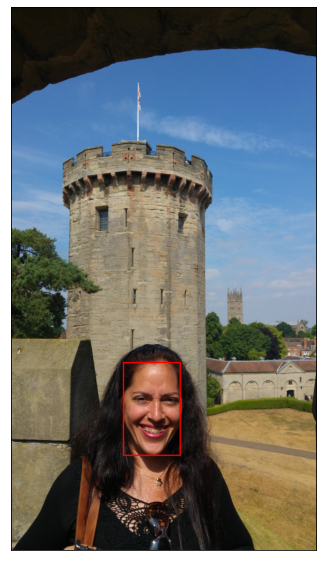

In [184]:
plt.figure(figsize=(10,10))
plt.xticks([])
plt.yticks([])
plt.imshow(img)

Función para detectar rostros. Todos los rostros que sean detectados

In [0]:
def detectface(client, filename):
  image=openImage(filename)
  response=client.detect_faces(Image={'Bytes': image}, Attributes=["ALL"])
  #img = plt.imread(filename)
  img = rotate(filename)
  faces=response['FaceDetails']
  for f in faces:
    box = f['BoundingBox']
    img,_=rectFace(img,box)
  return img 

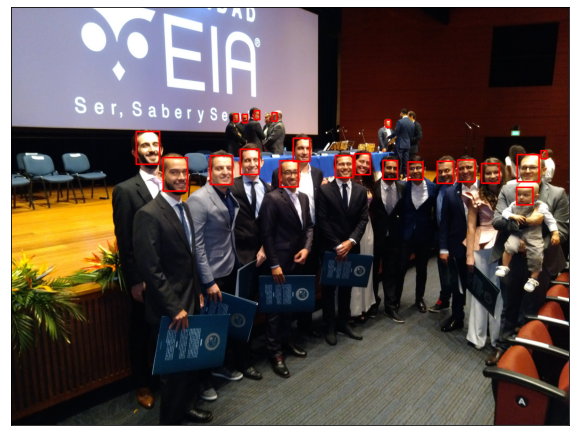

In [252]:
plt.figure(figsize=(10,10))
img=detectface(client,grupoI)
plt.xticks([])
plt.yticks([])
plt.imshow(img)

## Comparación de rostros

La función ***compare_face*** permite comparar un rostro de una imagen pasada en el parámtro *SourceImage*, en otra imagen pasada como parámetro en *TargetImage*

In [0]:
image1=openImage(face)
image2=openImage(grupoI)
response=client.compare_faces(TargetImage={'Bytes': image2}, SourceImage={'Bytes': image1})

In [0]:
faces=response['FaceMatches']
box=response['FaceMatches'][0]['Face']['BoundingBox']
img = rotate(grupoI)
img,_=rectFace(img,box)

Función para encontrar el rostro de la imagen *SourceImage*

In [0]:
def compareFaces(fileSource, fileTarget):
  image1=openImage(fileSource)
  image2=openImage(fileTarget)
  response=client.compare_faces(TargetImage={'Bytes': image2}, SourceImage={'Bytes': image1})
  faces=response['FaceMatches']
  box=response['FaceMatches'][0]['Face']['BoundingBox']
  image1=rotate(fileSource)
  img = rotate(fileTarget)
  img,_=rectFace(img,box)
  return image1,img

([], <a list of 0 Text major ticklabel objects>)

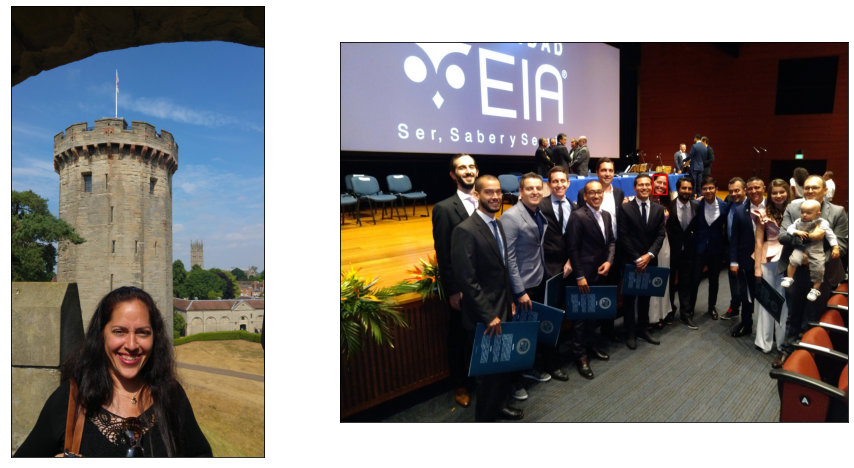

In [323]:
from matplotlib import gridspec
img1,img2=compareFaces(face, grupoI)
plt.figure(figsize=(15,15))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 2])
#plt.subplot(1, 2, 1)
plt.subplot(gs[0])
plt.imshow(img1)
plt.xticks([])
plt.yticks([])
#plt.subplot(1, 2, 2)
plt.subplot(gs[1])
plt.imshow(img2)
plt.xticks([])
plt.yticks([])

## Detección de objetos

In [0]:
image=openImage(cuba)
response = client.detect_labels(Image={'Bytes': image})

In [309]:
labels=[(e['Name'], e['Confidence']) for e in response['Labels']]
for e in labels:
  print(e)

('Shorts', 99.87698364257812)
('Clothing', 99.87698364257812)
('Apparel', 99.87698364257812)
('Human', 98.02891540527344)
('Person', 98.02891540527344)
('Accessories', 93.4618148803711)
('Accessory', 93.4618148803711)
('Sunglasses', 93.4618148803711)
('Road', 90.68086242675781)
('Transportation', 90.4419174194336)
('Vehicle', 90.4419174194336)
('Automobile', 90.4419174194336)
('Car', 90.4419174194336)
('City', 90.3569564819336)
('Urban', 90.3569564819336)
('Town', 90.3569564819336)
('Metropolis', 90.3569564819336)
('Building', 90.3569564819336)
('Asphalt', 89.44056701660156)
('Tarmac', 89.44056701660156)
('Sleeve', 85.44308471679688)
('Machine', 75.34337615966797)
('Wheel', 75.34337615966797)
('Intersection', 72.91020202636719)
('Architecture', 59.14814376831055)
('Long Sleeve', 56.619407653808594)
('Downtown', 55.6287956237793)
('Parking', 55.15337371826172)
('Parking Lot', 55.15337371826172)
('Undershirt', 55.07787322998047)


In [0]:
def detectobjects(filename):
  image=openImage(filename)
  response = client.detect_labels(Image={'Bytes': image})
  img=rotate(filename)
  for l in response['Labels']:
    name=l['Name']
    for i in l['Instances']:
      box=i['BoundingBox']
      img,v=rectFace(img,box)
      img=cv2.putText(img, name, (v[0],v[1]), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 255), 4, cv2.LINE_AA)
  return img

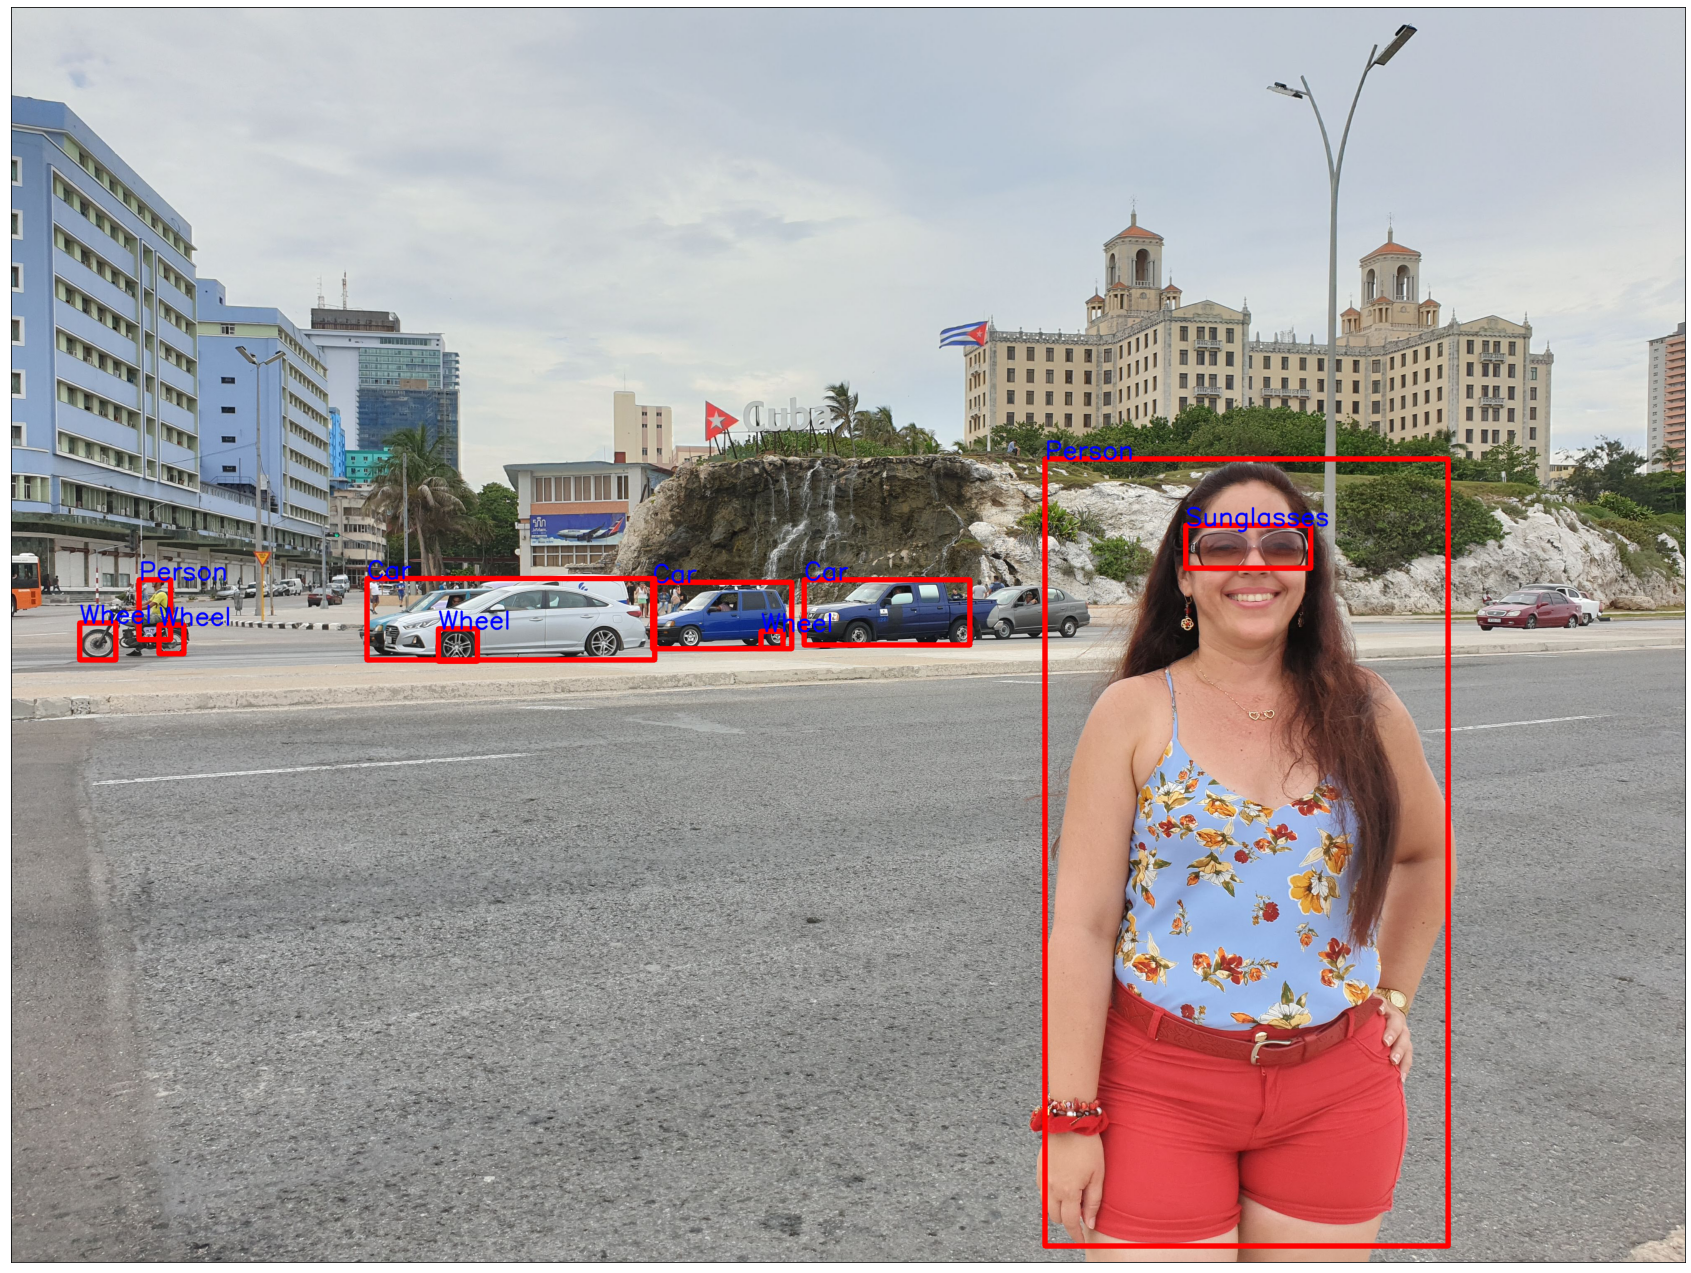

In [308]:
img=detectobjects(cuba)
plt.figure(figsize=(30,30))
plt.xticks([])
plt.yticks([])
plt.imshow(img)

In [0]:
image=openImage(filename)
response = client.detect_text(Image={'Bytes': image})
client.detect_text